# **MRI Brain Alzheimer Classification - Dino V2**

**Clone Dataset from GitHub**

In [1]:
# Check if the directory exists and clone if it does not
# !if [ ! -d "MRI_Brain_Alzheimer_Classification" ]; then git clone https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification; fi

# Change directory to the cloned repository
# %cd MRI_Brain_Alzheimer_Classification
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Barin_Alzheimer_Classification


**Install Packages**

In [2]:
# # !git clone https://github.com/facebookresearch/dinov2.git
# !pip install --no-deps -r requirements.txt 

# !pip show xformers || pip3 install -U xformers --index-url https://download.pytorch.org/whl/cu124
# !pip show torchvision || pip install torchvision
# !pip show optuna || pip install optuna
# !pip show tqdm || pip install tqdm

**Import Packages**

In [3]:
# Suppress user and future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# imports
import sys
import os
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time


# repository imports
from models import def_models
from utils import utils_funcs
from utils import optuna_search


**Device Definition**

In [4]:
# check if there is a CUDA device available 
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()

torch.cuda.is_available(): True
device: cuda:0


**Load the Dataset**

In [5]:
train_set = torch.load('dataset/dataset_variables/train_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')

**Pre-processing of the data**

In [6]:
# Resize images from 128x128 to 224x224 transformation
preprocess = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

# Apply transformations to the datasets
train_set = utils_funcs.apply_transformations(train_set, preprocess)
validation_set = utils_funcs.apply_transformations(validation_set, preprocess)
test_set = utils_funcs.apply_transformations(test_set, preprocess)

**Model Definition and Initialization**

In [7]:
# Initialize in,out channels, width and height sizes
input_channels = 3
width = 224
height = 224
output_channels = 4

dino_v2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# freeze dino_v2 layers
for param in dino_v2_model.parameters():
    param.requires_grad = False
    

# make the model
model = def_models.DINO_v2_FT(dino_backbone=dino_v2_model, output_channels=output_channels).to(device)

Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main


**Model Statistics**

In [8]:
# model statistics
model_name = type(model).__name__
print("model ", model_name," statistics")
summary(model, (input_channels, height, width))

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

model  DINO_v2_FT  statistics
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
            Linear-6             [-1, 257, 384]         147,840
           Dropout-7             [-1, 257, 384]               0
   MemEffAttention-8             [-1, 257, 384]               0
        LayerScale-9             [-1, 257, 384]               0
        LayerNorm-10             [-1, 257, 384]             768
           Linear-11            [-1, 257, 1536]         591,360
             GELU-12            [-1, 257, 1536]               0
          Dropout-13            [-1, 257, 1536]               0
         

**Optuna**

In [9]:
params = optuna_search.optuna_param_search(model_name="DINO_v2_FT", loss_criterion=nn.CrossEntropyLoss(), num_epochs_for_experiments=10, device=device,transfer_learning=True)
print(params)

[I 2024-10-01 23:22:37,268] A new study created in memory with name: mri-alzhimer-classification


Optuna is done on device: cuda:0


Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main
100%|██████████| 10/10 [07:58<00:00, 47.85s/it]
[I 2024-10-01 23:30:49,978] Trial 0 finished with value: 0.8 and parameters: {'lr': 0.018043434846857755, 'optimizer': 'SGD', 'batch_size': 256, 'scheduler': 'CosineAnnealingLR'}. Best is trial 0 with value: 0.8.
Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main
100%|██████████| 10/10 [08:11<00:00, 49.11s/it]
[I 2024-10-01 23:39:16,316] Trial 1 finished with value: 0.8125 and parameters: {'lr': 0.019037268193414877, 'optimizer': 'Adam', 'batch_size': 64, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.8125.
Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main
100%|██████████| 10/10 [08:51<00:00, 53.18s/it]
[I 2024-10-01 23:48:22,944] Trial 2 finished with value: 0.6109375 and parameters: {'lr': 1.6026016667283474e-06, 'optimizer': 'Adam', 'batch_size': 64, 'scheduler': 'StepLR'}. B

Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  24
  Number of complete trials:  16
Best trial:
  Value:  0.9109375
  Params: 
    lr: 0.00014209161863054374
    optimizer: Adam
    batch_size: 128
    scheduler: CosineAnnealingLR
Best parameters saved to checkpoints/op_tuna_params\DINO_v2_FT\DINO_v2_FT_0.9109.json
{'lr': 0.00014209161863054374, 'optimizer': 'Adam', 'batch_size': 128, 'scheduler': 'CosineAnnealingLR'}


**Hyper-Parameters**

In [10]:
# Hyper-parameters
batch_size = params['batch_size']
learning_rate = params['lr']
optimizer_name = params['optimizer']
scheduler = params['scheduler']

num_epochs = 50

# loss criterion
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = getattr(torch.optim, optimizer_name)(model.fc.parameters(), lr=learning_rate)

# scheduler
scheduler = StepLR(optimizer, 10, 0.1, verbose=True) if scheduler == "StepLR" else CosineAnnealingLR(optimizer, num_epochs, verbose=True)


augmentations = K.AugmentationSequential(
        K.RandomHorizontalFlip(p=0.1),
        K.RandomVerticalFlip(p=0.1),
        K.RandomRotation(degrees=10, p=0.1),
        K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.1),
        K.RandomBrightness(brightness=(0.8, 1.2), p=0.1),
        K.RandomContrast(contrast=(0.8, 1.2), p=0.1),
        K.RandomGamma(gamma=(0.9, 1.1), p=0.1),
        K.RandomSharpness(p=0.1),
        same_on_batch=False
)


**Prepare the data**

In [11]:
# Combine train_set and val_set into one dataset and
combined_train_val_set = ConcatDataset([train_set, validation_set])

# Loading the data and shuffling it
trainloader = torch.utils.data.DataLoader(combined_train_val_set, batch_size=batch_size, shuffle=True, num_workers=6,pin_memory=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=6,pin_memory=True)

**Train Model**

In [12]:
epoch_losses = utils_funcs.train(model, num_epochs, trainloader, device, criterion, optimizer, scheduler, augmentations)

Training model: DINO_v2_FT on cuda:0
Epoch: 1 | Loss: 0.9464 | Training accuracy: 81.289% | Epoch Time: 205.86 secs
Epoch: 2 | Loss: 0.5638 | Training accuracy: 90.625% | Epoch Time: 202.58 secs
Epoch: 3 | Loss: 0.4099 | Training accuracy: 95.605% | Epoch Time: 206.34 secs
Epoch: 4 | Loss: 0.2903 | Training accuracy: 98.535% | Epoch Time: 224.43 secs
Epoch: 5 | Loss: 0.2462 | Training accuracy: 97.871% | Epoch Time: 175.39 secs
==> Saving model ...
saved as ./checkpoints/DINO_v2_FT_043456_02102024.pth
Epoch: 6 | Loss: 0.2209 | Training accuracy: 98.945% | Epoch Time: 202.57 secs
Epoch: 7 | Loss: 0.1860 | Training accuracy: 99.707% | Epoch Time: 230.42 secs
Epoch: 8 | Loss: 0.1698 | Training accuracy: 99.297% | Epoch Time: 169.88 secs
Epoch: 9 | Loss: 0.1589 | Training accuracy: 99.727% | Epoch Time: 275.78 secs
Epoch: 10 | Loss: 0.1479 | Training accuracy: 99.668% | Epoch Time: 211.13 secs
==> Saving model ...
saved as ./checkpoints/DINO_v2_FT_045306_02102024.pth
Epoch: 11 | Loss: 0.13

**Load fine-tuned parameters**

In [13]:
# model_path = './checkpoints/DINO_v2_FT_055736_30092024.pth'
# checkpoint = torch.load(model_path,weights_only=True)
# last_epoch, last_loss = utils_funcs.load_model(model, optimizer, model_path)
# model.load_state_dict(checkpoint['net'])

**Results**

<Figure size 800x600 with 0 Axes>

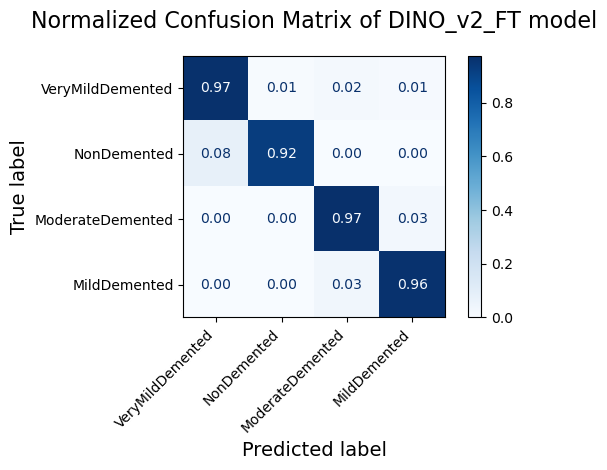

In [14]:
class_names = ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']
utils_funcs.plot_normalized_confusion_matrix(testloader, model, class_names, device, model_name)

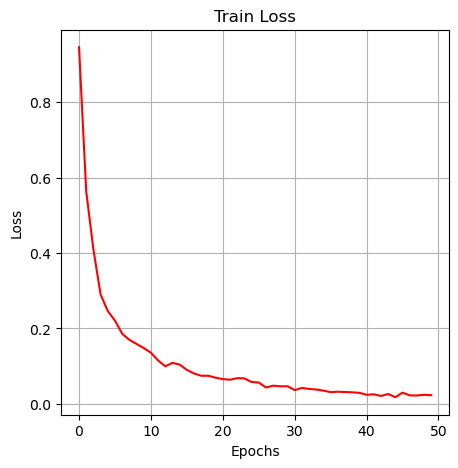

In [15]:
utils_funcs.plot_loss_curve(epoch_losses, num_epochs)

In [16]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 96.953%
